In [1]:
import os
import numpy as np
import random
from matplotlib import pyplot as plt
import cv2
from PIL import Image

In [2]:
%matplotlib inline
plt.style.use('dark_background')

In [3]:
# path_to_folder = '/content/drive/MyDrive/SMAI Project/'
path_to_folder = './'

## Get Face Matrix

In [4]:
def load_dataset(dataset="FEI",im_size=(58,49),RANDOM_SEED=None):
    """
    Takes input as name of dataset used (optional), size the images should be
    resized to in the format (columns,rows) (optional) and the random seed to
    reproduce results (optional, keep None if no seed is to be used).
    Returns four lists, two lists of images as training and testing, where
    testing dataset has one image of each person, and two more lists of the
    labels of the images.
    """
    if RANDOM_SEED is not None:
        random.seed(RANDOM_SEED)
    if dataset == "FEI":
        training_im, testing_im, training_label, testing_label = [], [], [], []
        for i in range(1,201):
            im_a = cv2.imread(path_to_folder+"FEIDataset/"+str(i)+"a.jpg",0)
            im_a = cv2.resize(im_a, im_size, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
            im_b = cv2.imread(path_to_folder+"FEIDataset/"+str(i)+"b.jpg",0)
            im_b = cv2.resize(im_b, im_size, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
            if random.randint(0,1) == 1:
                training_im.append(im_a)
                testing_im.append(im_b)
            else:
                training_im.append(im_b)
                testing_im.append(im_a)
            training_label.append(i)
            testing_label.append(i)
    else:
        training_im, testing_im, training_label, testing_label = [], [], [], []
        types = [
            "centerlight", "glasses", "happy", "leftlight", "noglasses",
            "normal", "rightlight", "sad", "sleepy", "surprised", "wink"
        ]
        for i in range(1,16):
            im = {}
            testing_type = random.choice(types)
            for t in types:
                im[t] = np.array(Image.open(path_to_folder+"YaleDataset/subject"+str(i).zfill(2)+"."+t),'uint8')
                im[t] = cv2.resize(im[t], im_size, fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
                if t == testing_type:
                    testing_im.append(im[t])
                    testing_label.append(i)
                else:
                    training_im.append(im[t])
                    training_label.append(i)
    return training_im, testing_im, training_label, testing_label

In [5]:
def get_face_matrices(im_list):
    """
    Takes input as list of images.
    Returns face matrix, mean face array and normalised face matrix.
    """
    face_matrix = np.vstack([im.flatten() for im in im_list])
    mean_face_array = np.mean(face_matrix,axis=0)
    norm_face_matrix = face_matrix-mean_face_array
    return face_matrix, mean_face_array, norm_face_matrix

In [6]:
X_train, X_test, Y_train, Y_test = load_dataset(dataset="Yale", RANDOM_SEED=0)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [7]:
face_matrix, mean_face_array, norm_face_matrix = get_face_matrices(X_train)

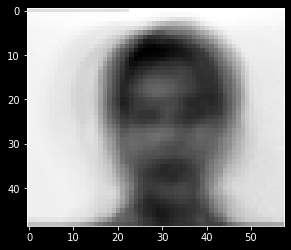

In [8]:
mean_face = mean_face_array.reshape(49,58)
plt.imshow(mean_face,cmap='gray',vmin=np.amin(mean_face),vmax=np.amax(mean_face))

## Get Eigen Values and Vectors of Covariance Matrix

In [9]:
def eigen(norm_face_matrix,dim=7):
    """
    Takes input as normalised face matrix, and number of eigen vectors to be
    considered (optional).
    Returns the array of required number of eigen values sorted in descending
    order, and matrix of eigen vectors corresponding to the eigen values.
    """
    eigen_vecs, eigen_vals, V = np.linalg.svd(np.cov(norm_face_matrix.T))
    eigen_vecs = eigen_vecs.T[np.argsort(eigen_vals)[-dim:][::-1]].T
    eigen_vals = np.sort(eigen_vals)[-dim:][::-1]
    return eigen_vals, eigen_vecs

In [10]:
eigen_vals, eigen_vecs = eigen(norm_face_matrix=norm_face_matrix,dim=20)

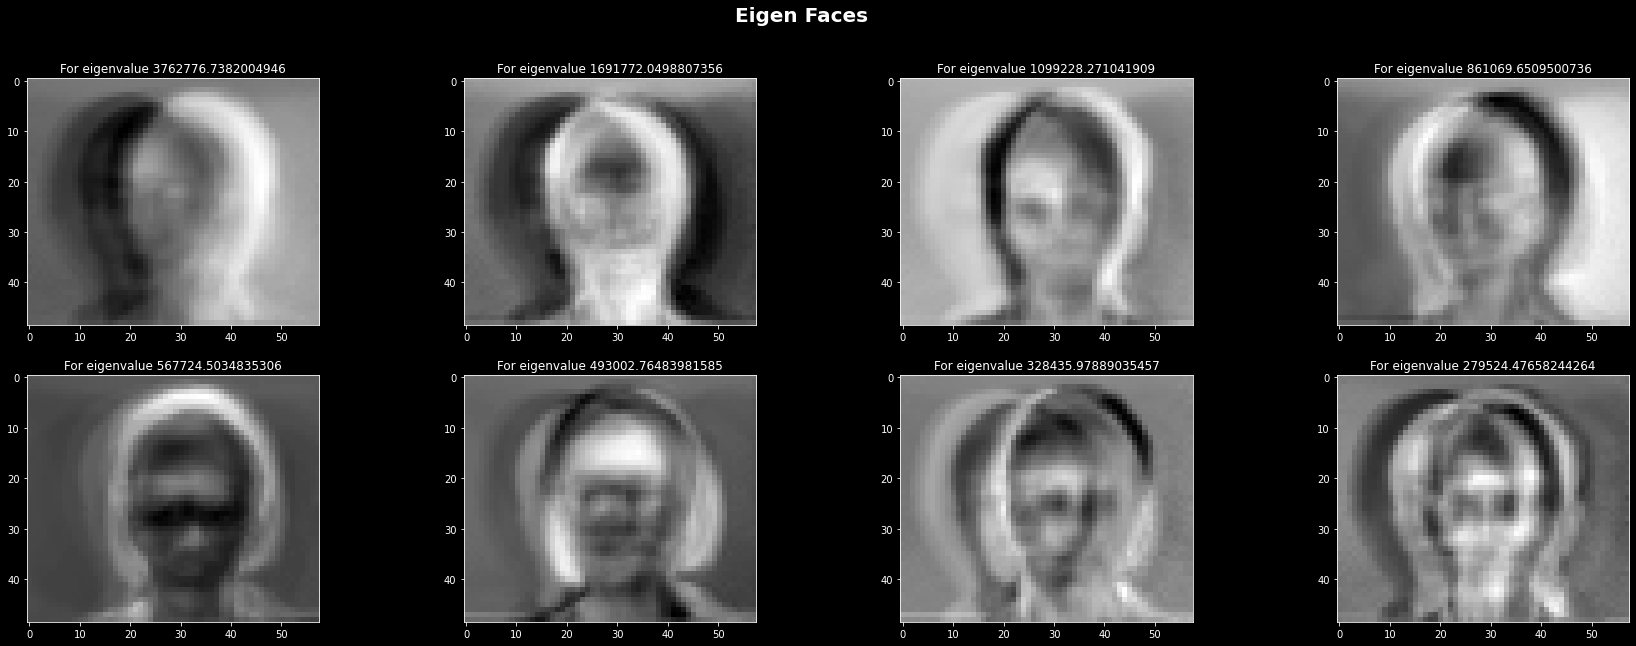

In [11]:
f,ax = plt.subplots(nrows=2,ncols=4,figsize=(30,10))
for i in range(8):
    ax[i//4,i%4].imshow(eigen_vecs[:,i].reshape(49,58),cmap='gray',vmin=np.amin(eigen_vecs[:,i]),vmax=np.amax(eigen_vecs[:,i]))
    ax[i//4,i%4].set_title(f"For eigenvalue {eigen_vals[i]}")
f.suptitle("Eigen Faces",fontsize=20,fontweight ="bold")
plt.show()

## Get dimensionally reduced weights of training images

In [12]:
def get_weights(norm_face_matrix, eigen_vecs):
    """
    Takes input as normalised face matrix and matrix of eigen vectors.
    Returns matrix of dimensionally reduced weights of training images.
    """
    return norm_face_matrix @ eigen_vecs

In [13]:
w = get_weights(norm_face_matrix=norm_face_matrix,eigen_vecs=eigen_vecs)

## Test your model

#### Using Nearest Neighbour in dimensionally reduced space

In [14]:
def get_labels(im_list,eigen_vecs,w_train,Y_train):
    """
    Takes input as list of images whose labels are to be found, matrx of eigen
    vectors, weight matrix of training dataset images and their labels.
    Returns the array of labels of the given image list.
    """
    Y_result = []
    for im in im_list:
        w_test = im.flatten() @ eigen_vecs
        Y_result.append(Y_train[np.argmin(np.sum((w_train-w_test)**2,axis=1))])
    return np.array(Y_result)

In [15]:
Y_result = get_labels(im_list=X_test,eigen_vecs=eigen_vecs,w_train=w,Y_train=Y_train)

In [16]:
print(f"Accuracy is {np.sum(Y_result==Y_test)*100/Y_result.shape[0]}%")

Accuracy is 20.0%


In [17]:
# neutral_faces = []
# for i in range(1,201):
#     im = cv2.imread(path_to_folder+"dataset/"+str(i)+"a.jpg",0)
#     im = cv2.resize(im, (58,49), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
#     neutral_faces.append(im.flatten())

In [18]:
# face_matrix = np.vstack(neutral_faces)
# face_matrix, face_matrix.shape

In [19]:
# def eigen(mat):
#     new_mat = mat - np.mean(mat,axis=0)
#     cov = (new_mat.T @ new_mat) / (mat.shape[0]-1)

In [20]:
# dim = mean_face_array.shape[0]
# eigen_vecs, eigen_vals, V = np.linalg.svd(np.cov((face_matrix-mean_face_array).T))
# eigen_vecs = eigen_vecs.T[np.argsort(eigen_vals)[-dim:][::-1]].T
# eigen_vals = np.sort(eigen_vals)[-dim:][::-1]

In [21]:
# eigen_vecs = eigen_vecs.T[np.argsort(eigen_vals)].T

In [22]:
# eigen_vecs @ np.diag(eigen_vals) @ V, np.cov((face_matrix-mean_face_array).T)

In [23]:
# projected_data = (face_matrix.T @ eigen_vecs).T
# projected_data, projected_data.shape

In [24]:
# f,ax = plt.subplots(nrows=2,ncols=4,figsize=(30,10))
# for i in range(7):
#     ax[i//4,i%4].imshow(projected_data[i].reshape(49,58),cmap='gray')
# ax[1,3].axis('off')
# plt.show()

In [25]:
# w = (face_matrix-mean_face_array) @ eigen_vecs
# w, w.shape, face_matrix-mean_face_array

In [26]:
# results = []
# for i in range(1,201):
#     test_im = cv2.imread(path_to_folder+"dataset/"+str(i)+"b.jpg",0)
#     test_im_resize = cv2.resize(test_im, (58,49), fx=0.5, fy=0.5, interpolation = cv2.INTER_AREA)
#     w_test = test_im_resize.flatten() @ eigen_vecs
#     results.append(np.argmin(np.sum((w-w_test)**2,axis=1))+1)
# results = np.array(results)
# print(f"Accuracy is {np.sum(results==np.arange(1,201))*100/results.shape[0]}%")
# results
# # print(str(index)+"a.jpg")
# # result_im = cv2.imread(path_to_folder+"dataset/"+str(index)+"a.jpg",0)
# # f,ax = plt.subplots(nrows=1,ncols=2,figsize=(30,30))
# # ax[0].imshow(test_im,cmap='gray')
# # ax[0].set_title("Test image")
# # ax[1].imshow(result_im,cmap='gray')
# # ax[1].set_title("Result image")
# # plt.show()